<div style="text-align: center;">
    <h1>CA3 - HMM</h1>
</div>

<div style="text-align: center;">
    Amirmahdi Farzane
    810100194
</div>

In [123]:
from google.colab import files
import librosa
import numpy as np
import os
from python_speech_features import mfcc, logfbank
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt
from hmmlearn import hmm
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import librosa
from hmmlearn import hmm
from python_speech_features import mfcc
from scipy.io import wavfile
import speechpy
from sklearn.model_selection import train_test_split
import pickle
import seaborn as sns
from tabulate import tabulate
from scipy.stats import multivariate_normal
from sklearn.metrics import classification_report


In [125]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [127]:
import matplotlib as plt

In [128]:
import librosa.display

In [ ]:
!pip install python_speech_features
!pip install speechpy

In [ ]:
!pip install hmmlearn

In [ ]:

import matplotlib.pyplot as plt
import itertools
import os
genre_list = ["blues","hiphop","metal","pop"]
# print(len(genre_list))
figure = plt.figure(figsize=(20,3))
for idx ,genre in enumerate(genre_list):
   example_data_path = "data/train/" + genre
   file_paths = glob.glob(path.join(example_data_path, "*.wav"))
   sampling_freq, audio = wavfile.read(file_paths[0])
   mfcc_features = mfcc(audio, sampling_freq, nfft=1024)
   print(file_paths[0], mfcc_features.shape[0])
   plt.yscale("linear")
   plt.matshow((mfcc_features.T)[:,:300])
   print(mfcc_features.T.shape)
   plt.text(150, -10, genre, horizontalalignment="center", fontsize=20)

plt.yscale("linear")
plt.show()

In [132]:
class HMM:
    def __init__(self, num_hidden_states):
        self.num_hidden_states = num_hidden_states
        self.rand_state = np.random.RandomState(1)

        self.initial_prob = self._normalize(self.rand_state.rand(self.num_hidden_states, 1))
        self.transition_matrix = self._stochasticize(self.rand_state.rand(self.num_hidden_states, self.num_hidden_states))

        self.mean = None
        self.covariances = None
        self.num_dimensions = None

    def _forward(self, observation_matrix):
        log_likelihood = 0.
        T = observation_matrix.shape[1]
        alpha = np.zeros(observation_matrix.shape)

        for t in range(T):
            if t == 0:
                alpha[:,0] = self.initial_prob[:,0] * observation_matrix[:,0]
            else:
                alpha[:,t] = np.matmul(self.transition_matrix.T,alpha[:,t-1]) * observation_matrix[:,t]

            alpha_sum = np.sum(alpha[:, t])
            alpha[:, t] /= alpha_sum
            log_likelihood += np.log(alpha_sum)

        return log_likelihood, alpha

    def _backward(self, observation_matrix):
        T = observation_matrix.shape[1]
        beta = np.zeros(observation_matrix.shape)

        beta[:, -1] = np.ones(observation_matrix.shape[0])

        for t in range(T - 1)[::-1]:
            beta[:, t] =  np.matmul(self.transition_matrix,(beta[:,t+1] * observation_matrix[:,t+1] ))
            beta[:, t] /= np.sum(beta[:, t])

        return beta

    def _state_likelihood(self, obs):
        obs = np.atleast_2d(obs)
        B = np.zeros((self.num_hidden_states, obs.shape[1]))

        for s in range(self.num_hidden_states):
            np.random.seed(self.rand_state.randint(1))
            B[s, :] = multivariate_normal.pdf(obs.T,mean =self.mean[:,s],cov = self.covariances[:,:,s])


        return B

    def _normalize(self, x):
        return (x + (x == 0)) / np.sum(x)

    def _stochasticize(self, x):
        return (x + (x == 0)) / np.sum(x, axis=1)

    def _em_init(self, obs):
        if self.num_dimensions is None:
            self.num_dimensions = obs.shape[0]
        if self.mean is None:
            subset = self.rand_state.choice(np.arange(self.num_dimensions), size=self.num_hidden_states, replace=False)
            self.mean = obs[:, subset]
        if self.covariances is None:
            self.covariances = np.zeros((self.num_dimensions, self.num_dimensions, self.num_hidden_states))
            self.covariances += np.diag(np.diag(np.cov(obs)))[:, :, None]

        return self

    def _em_step(self, obs):
        obs = np.atleast_2d(obs)
        T = obs.shape[1]

        B = self._state_likelihood(obs)

        log_likelihood, alpha = self._forward(B)
        beta = self._backward(B)

        xi_sum = np.zeros((self.num_hidden_states, self.num_hidden_states))
        gamma = np.zeros((self.num_hidden_states, T))

        for t in range(T - 1):
            partial_sum = self.transition_matrix * np.matmul((beta[:,t+1].T * B[:,t+1].T) , alpha[:,t])
            xi_sum += self._normalize(partial_sum)
            partial_g = alpha[:,t] * beta[:,t]
            gamma[:, t] = self._normalize(partial_g)
        partial_g = alpha[:,T-1] * beta[:,T-1]
        gamma[:, -1] = self._normalize(partial_g)

        expected_prior = np.reshape(gamma[:, 0],(-1,1))
        expected_transition = self._stochasticize(xi_sum/np.sum(xi_sum,axis=(0,1)))

        expected_covariances = np.zeros((self.num_dimensions, self.num_dimensions, self.num_hidden_states))
        expected_covariances += .01 * np.eye(self.num_dimensions)[:, :, None]

        gamma_state_sum = np.sum(gamma, axis=1)
        gamma_state_sum = gamma_state_sum + (gamma_state_sum == 0)

        expected_mean = np.zeros((self.num_dimensions, self.num_hidden_states))
        for s in range(self.num_hidden_states):
            gamma_obs = obs * gamma[s, :]
            expected_mean[:, s] = np.sum(gamma_obs, axis=1) / gamma_state_sum[s]

        self.initial_prob = expected_prior
        self.mean = expected_mean
        self.covariances = expected_covariances
        self.transition_matrix = expected_transition

        return log_likelihood

    def train(self, obs, num_iterations=10):
        for i in range(num_iterations):
            self._em_init(obs)
            self._em_step(obs)
        return self

    def score(self, obs):
        B = self._state_likelihood(obs)
        log_likelihood, _ = self._forward(B)
        return log_likelihood


**Q1** :
We must use samples with same legth because model is senesitive on samples length it means observations' base properties must be same . This model's obsevation is mfcc features of frames of samples and for each sample we must use same number of frames to get simmilar obsrvations and diffrance is just in value of mfcc features and our model so samples must have same length.

**Q2**



**Q3** :
The MFCC model takes the first 12 or 13 coefficients of the signal because along with the these coefficients, it will take the energy of the signal sample as the feature. It will help in identifying the phones and cover human voice well so we don't need all features.Beside of that , low coeffitents will reduce comutational cost .

# HMM - Questions

# Q1:
**Hidden states** that transition from one to another, and each hidden state is associated with a probability distribution over observable outcomes and our model is in each state at each time. The sequence of **observations** provides information about the sequence of hidden states, and the model is trained to learn these hidden states based on observed data .
We see observations and find hidden states' probability distribution based on those.

As i sayed in previous part in this problem **Observations** are mfcc coefficients of frames for audios . That model detect pattern by these coefficients.

**States** can be every thing that represent an onobsevabel pattern in musics that we can't detect that but by hmm we can find .

# Q2:

Because each hidden state is directly associated with a single observation, forming a straightforward Markov chain. This simplicity arises from the assumption that the current state is solely influenced by the immediate past, resulting in a computationally efficient model. Despite its simplicity, a first-order HMM exhibits versatility, proving effective in scenarios characterized by short-term dependencies within the sequence.

# Q3:

Hidden Markov Models (HMMs) are suitable for analyzing sequential data with hidden states. They find applications in speech recognition, natural language processing, bioinformatics, finance, computer vision,  and economics. HMMs is good in scenarios where there are hidden structures and sequential dependencies in the data, and is powerful tool for probabilistic modeling in dynamic environments.

# Q4:

**Advantages of HMMs**

1 - *Effective for modeling sequential data*

because it has states that depend on each other and so by means of this dependency we can represent sequential data.

2 - *Flexible representation of systems with hidden states*

because allows for a versatile representation of systems with hidden states, making them adaptable to various types of patterns in the data.

3 - *Interpretable hidden states*

because it provides insights into the characteristics or patterns captured by each hidden state

**disadvantages of HMMs**

1 - *Fixed State Space*

it has a fixed and known set of hidden states, which might not always align with the true underlying structure of the data. so can be restrictive in situations where the number or nature of states is uncertain.So we must try again and again to fine better number of sates.

2 - *Computational Complexity*

Training HMMs and making predictions involve computations related to probabilities and sequences, which can be computationally intensive, especially for large datasets.

3 - *Markovian Assumption*

 meaning that the future state depends only on the current state and not on the sequence of events leading to that state. This limitation may not capture long-term dependencies in the data.

# Q5:

1 - *First-Order*

Each hidden state has a direct connection to one observation, forming a simple Markov chain.

2 - *Multivariate*

Handles multiple observation sequences, each associated with a different set of hidden states.

3 - *Gaussian Mixture*

Employs a mixture of Gaussian distributions to model continuous observations in each hidden state.

4 - *Hidden Semi-Markov*

Extends HMMs by allowing variable-duration states, accommodating more complex temporal patterns.

In [146]:
class HMMTrainer(object):
  def __init__(self, n_components=4,  n_iter=13):
    self.model_name = 'GaussianHMM'
    self.n_components = n_components
    self.cov_type = 'diag'
    self.n_iter = n_iter
    self.models = []
    self.model = hmm.GaussianHMM(n_components=self.n_components, covariance_type=self.cov_type, n_iter=self.n_iter)


  def train(self, X):
    np.seterr(all='ignore')
    self.models.append(self.model.fit(X))

  def get_score(self, input_data):
    return self.model.score(input_data)

In [147]:
hmm_models = []
my_hmm_models = []
input_folder = 'data/train/'

for dirname in os.listdir(input_folder):

    subfolder = os.path.join(input_folder, dirname)
    if not os.path.isdir(subfolder):
        continue

    label = subfolder[subfolder.rfind('/') + 1:]

    X = np.array([])
    y_words = []

    for filename in [x for x in os.listdir(subfolder) if x.endswith('.wav')]:

            filepath = os.path.join(subfolder, filename)
            # print(filepath)
            sampling_freq, audio = wavfile.read(filepath)

            mfcc_features = mfcc(audio, sampling_freq ,nfft=1024)
            # print(mfcc_features.shape)

            if len(X) == 0:
                X = mfcc_features
            else:
                X = np.append(X, mfcc_features, axis=0)
            y_words.append(label)
    print('X.shape =', X.shape)

    hmm_trainer = HMMTrainer()
    hmm_trainer.train(X)
    hmm_models.append((hmm_trainer, label))

    my_hmm = HMM(5)
    my_hmm.train(X.T / np.amax(X.T),6)
    my_hmm_models.append(my_hmm)

X.shape = (239520, 13)
X.shape = (239360, 13)
X.shape = (240261, 13)
X.shape = (239414, 13)


In [ ]:
input_folder = 'data/test/'
real_labels = []
pred_labels = []
my_model_pred_labels = []
for dirname in os.listdir(input_folder):

  subfolder = os.path.join(input_folder, dirname)
  if not os.path.isdir(subfolder):
    continue
  # Extract the label
  label_real = subfolder[subfolder.rfind('/') + 1:]

  for filename in [x for x in os.listdir(subfolder) if x.endswith('.wav')]:
    real_labels.append(label_real)
    filepath = os.path.join(subfolder, filename)
    sampling_freq, audio = wavfile.read(filepath)
    mfcc_features = mfcc(audio, sampling_freq, nfft=1024)
    max_score = -10**10
    my_model_max_score = -10**10
    output_label = None
    my_model_out_label = None
    for i in range(len(hmm_models)):
       hmm_model, label = hmm_models[i]
       my_hmm_model = my_hmm_models[i]
       score = hmm_model.get_score(mfcc_features)
       my_model_score = my_hmm_model.score(mfcc_features.T / np.amax(mfcc_features.T ))
       print(score)
       if score > max_score:
          max_score = score
          print("*",max_score)
          output_label = label

       if my_model_score > my_model_max_score:
          my_model_max_score = my_model_score
          my_model_out_label = label

    pred_labels.append(output_label)
    my_model_pred_labels.append(my_model_out_label)

In [149]:
def print_conf_matrix(real_labels , pred_labels):
    cm = confusion_matrix(real_labels, pred_labels)
    np.set_printoptions(precision=2)
    classes = ["blues","hiphop","metal","pop"]
    plt.figure()
    cmap=plt.cm.Greens

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title("Confusion matrix for genere classification")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j]),
                  horizontalalignment="center")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    plt.show()

# Evaluation part

 # Q1
 Acuuracy measures the proportion of correct predictions in the model. This measure may not be enough because in multiclass classification, our prediction on some classes are really good but our model is predictiong one class horribly. As a result we need more accurate measurements.

$Accuracy = \frac{True Predictions}{All Predictions}$

Recall is the ratio of true positive predictions out of actually positive data.

$Recall = \frac{True Positive}{True Positive + False Negative}$

precision for each class precision is the ratio of the true positive predictions out of all positive-predicted data.

$Precision = \frac{True Positive}{True Positive + False Positive}$

Finally F1 score is a balanced evaluation of Recall and precision and shows performance of the model. F1 score has a  value between 0 and 1.

$F1  = 2* \frac{Recall * Precision}{Recall + Precision}$


#Q2

Recall shows how well can model detect positive labels , on the other hand precision shows how predict of model for postitive label is well.

example of good recall and bad precison:

in second bellow report for metal genere recall is 1 and precision is 0.67 so model has bad performance . it could detect metal but all metal predicted labels are not correct . so just recall is not enough.

example of bad recall and good precison:

in first bellow report for hiphop genere recall is 0.1 and precision is 1.
 so model has bad performance . all of predictions are correct but coudn't predict all hiphops.



 # Q3

The F1-score  metric combines precision and recall to evaluate the performance of a classification model.

It is particularly useful when there is an uneven class distribution. The F1-score is calculated as the harmonic mean of precision and recall, providing a balanced measure that considers both false positives and false negatives, making it a valuable metric for assessing a model's overall accuracy in binary classification tasks.

Furthuremore because of harmonic mean calculation F1 is less sensitive to exrtreme and noisy data.

# Q4
These metrics give a evaluation for each class. To calculate total performance of our model we can use micro-average, macro-average and weighted-average.

$Total Precision Micro = \frac{\sum_{i=1}^{N_1} TP_i}{\sum_{i=1}^{N_1} TP_i + \sum_{i=1}^{N_2} FP_i} $

$Total Precision Macro = \frac{\sum_{i=1}^{N} Precision_{i}}{N} $

$Total Precision Weighted = \frac{\sum_{i=1}^{N} (\alpha_{i} * Precision_{i})}{\sum_{i=1}^{N} \alpha_{i}} $


1 - macro averages calculates precision or recall of each class and averages over them.

2 - micro we averages TP, NP, and FN then calculate the precision and recall. Micro averages along each instance while macro averages along each class.

3 - weighted average is like macro average but when we want to give some classes more or less importance.

# Q5


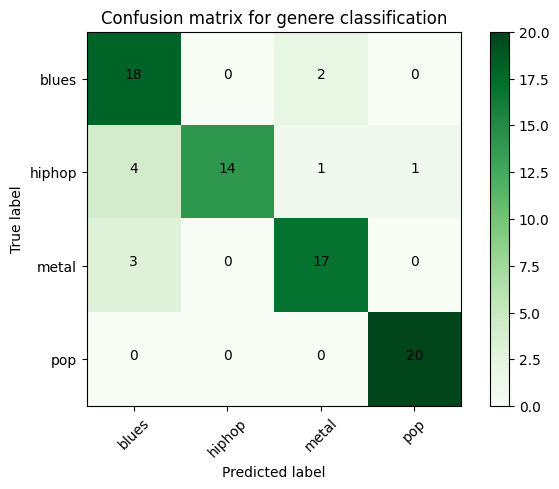

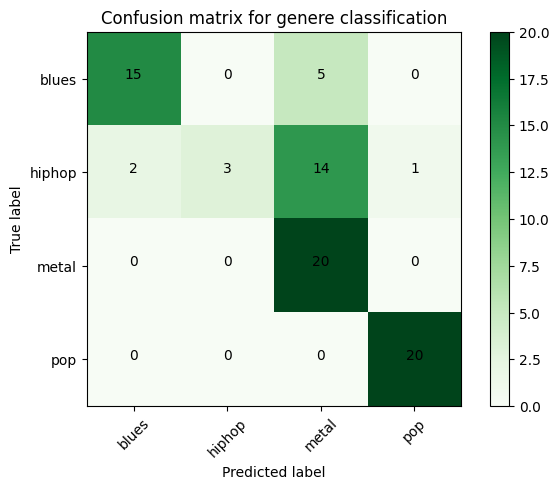

In [150]:
print_conf_matrix(real_labels , pred_labels)
print_conf_matrix(real_labels , my_model_pred_labels)

In [151]:
print(classification_report(real_labels, pred_labels, labels=classes))

              precision    recall  f1-score   support

       blues       0.72      0.90      0.80        20
      hiphop       1.00      0.70      0.82        20
       metal       0.85      0.85      0.85        20
         pop       0.95      1.00      0.98        20

    accuracy                           0.86        80
   macro avg       0.88      0.86      0.86        80
weighted avg       0.88      0.86      0.86        80



In [152]:
print(classification_report(real_labels, my_model_pred_labels, labels=classes))

              precision    recall  f1-score   support

       blues       0.88      0.75      0.81        20
      hiphop       1.00      0.15      0.26        20
       metal       0.51      1.00      0.68        20
         pop       0.95      1.00      0.98        20

    accuracy                           0.73        80
   macro avg       0.84      0.72      0.68        80
weighted avg       0.84      0.72      0.68        80



# Q6
As we see recall for hiphop is less than other generes so i listend to musics and i undrestood we have high simmilarity between metal and hiphop and besides that hiphop has more diversity i mean low and high musics and slow and fast Musical instrument so with this short data set covering all of them is hard .

On the other hand pop has perfect result and after listening to musics i undrestood that most of samples are simmilar so we can find appropriate patern in train to detect test samples.And simmilarity between pop and other generes is low.

I changed number of iterations from 10 to 50 but i got bad result in 50 iteration for hiphop so i setted on 13 . i checked diffrent numbers from 10 to 20 and 13 had the best result.

# Q7

The library model may use different hmm structures or do some hyperparamether optimization.

It can also run more complex algorithms efficiently. The most important thing is how the library model map observations to $ B $ matrix.

And in first method we used gaussian distribiotion that it works better for continious data as i sayed.


